In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict, Counter
from functools import reduce
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D
import torch

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.build
import data.constants as dconst
import model.constants as mconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [4]:
import logging as l

l.basicConfig(level=l.INFO)

In [5]:
dataset = dconst.AMAZON_PHOTO

In [6]:
config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
    },
    run = {
        'use_default_configuration' : True,
    },
)
config.model.use_bias = True
if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    
print(config.run.use_default_configuration)

INFO:root:Set configuration value data.base_labels to default all
INFO:root:Set configuration value data.corpus_labels to default all
INFO:root:Set configuration value data.train_labels to default all
INFO:root:Set configuration value data.left_out_class_labels to default ['Film Photography', 'Binoculars & Scopes', 'Video Surveillance']
INFO:root:Set configuration value data.preprocessing to default none
INFO:root:Set configuration value data.ood_sampling_strategy to default all
INFO:root:Set configuration value data.train_portion to default 20
INFO:root:Set configuration value data.test_portion_fixed to default 0.2
INFO:root:Set configuration value data.split_type to default uniform
INFO:root:Set configuration value data.type to default npz
INFO:root:Set configuration value data.drop_train_vertices_portion to default 0.1
INFO:root:Set configuration value data.precompute_k_hop_neighbourhood to default 2
INFO:root:Set configuration value model.hidden_sizes to default [64]
INFO:root:Set 

True


In [7]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
model_seed = next(model_seed_generator)
config.registry.model_seed = model_seed
config.registry.split_seed = data_split_seed
config.training.early_stopping.patience = 50
config.training.early_stopping.min_delta = 0.01

In [8]:
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)

INFO:root:Found precomputed dataset split at /nfs/students/fuchsgru/dataset_registry/3384787171.pt


In [9]:
from torch_geometric.data import DataLoader
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
import os.path as osp
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'reliability-diagram')

In [11]:
config.run.use_pretrained_model = True

if not torch.cuda.is_available():
    config.training.gpus = 0
    
config.training

TrainingConfiguration(max_epochs=1000, min_epochs=None, learning_rate=0.001, early_stopping=EarlyStoppingConfiguration(patience=50, mode='min', monitor='val_loss', min_delta=0.01), gpus=0, weight_decay=0.001, suppress_stdout=True, train_model=True, self_training=False, num_warmup_epochs=50, singular_value_bounding=False, singular_value_bounding_eps=0.01, orthonormal_weight_regularization_strength=0.0, orthonormal_weight_scale=1.0, finetuning=FinetuningConfiguration(max_epochs=10, min_epochs=1, enable=False, reconstruction=None, feature_reconstruction=None, reconstruction_weight=None, feature_reconstruction_weight=None), temperature_scaling=None)

In [12]:
model = make_model(config, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])).eval()
model = train_model(model, config, run_artifact_dir, data_loaders, logger=None).eval()
model.clear_and_disable_cache()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1088774128.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1088774128.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [13]:
from copy import deepcopy
config_sn = deepcopy(config)
config_sn.model.use_spectral_norm = True
config_sn.model.residual = True
config_sn.model.weight_scale = 200.0

model_sn = make_model(config_sn, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])).eval()
model_sn = train_model(model_sn, config_sn, run_artifact_dir, data_loaders, logger=None).eval()
model_sn.clear_and_disable_cache()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/860031892.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/860031892.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [14]:
from copy import deepcopy
config_rc = deepcopy(config)
config_rc.model.reconstruction.loss_weight = 1.0
config_rc.model.reconstruction.reconstruction_type = mconst.ENERGY


model_rc = make_model(config_rc, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])).eval()
model_rc = train_model(model_rc, config_rc, run_artifact_dir, data_loaders, logger=None).eval()
model_rc.clear_and_disable_cache()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/663886643.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/663886643.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [15]:
from copy import deepcopy
config_ts = deepcopy(config)
config_ts.training.temperature_scaling = configuration.TemperatureScalingConfiguration()

model_ts = make_model(config_ts, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])).eval()
model_ts = train_model(model_ts, config_ts, run_artifact_dir, data_loaders, logger=None).eval()
model_ts.clear_and_disable_cache()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1063075210066617360-1651070102-6772926-1496782358.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1063075210066617360-1651070102-6772926-1496782358.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [16]:
from copy import deepcopy
config_sn_ts = deepcopy(config)
config_sn_ts.model.use_spectral_norm = True
config_sn_ts.model.residual = True
config_sn_ts.model.weight_scale = 200.0
config_sn_ts.training.temperature_scaling = configuration.TemperatureScalingConfiguration()

model_sn_ts = make_model(config_sn_ts, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])).eval()
model_sn_ts = train_model(model_sn_ts, config_sn_ts, run_artifact_dir, data_loaders, logger=None).eval()
model_sn_ts.clear_and_disable_cache()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/1500661578638478049-1651075134-751009-3948178703.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/1500661578638478049-1651075134-751009-3948178703.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [17]:
from copy import deepcopy
config_rc_ts = deepcopy(config)
config_rc_ts.model.reconstruction.loss_weight = 1.0
config_rc_ts.model.reconstruction.reconstruction_type = mconst.ENERGY
config_rc_ts.training.temperature_scaling = configuration.TemperatureScalingConfiguration()


model_rc_ts = make_model(config_rc_ts, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0])).eval()
model_rc_ts = train_model(model_rc_ts, config_rc_ts, run_artifact_dir, data_loaders, logger=None).eval()
model_rc_ts.clear_and_disable_cache()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:root:Found pre-trained model at /nfs/students/fuchsgru/model_registry/-5217458571423062807-1651072533-6575155-1074682396.ckpt
INFO:root:Loading model for evaluation from /nfs/students/fuchsgru/model_registry/-5217458571423062807-1651072533-6575155-1074682396.ckpt.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [18]:
data_test = data_dict[dconst.TEST][0]

In [19]:
with torch.no_grad():
    scores_pred = model(data_test).get_predictions()[data_test.mask]
    scores_pred_sn = model_sn(data_test).get_predictions()[data_test.mask]
    scores_pred_rc = model_rc(data_test).get_predictions()[data_test.mask]
    scores_pred_ts = model_ts(data_test).get_predictions()[data_test.mask]
    scores_pred_sn_ts = model_sn_ts(data_test).get_predictions()[data_test.mask]
    scores_pred_rc_ts = model_rc_ts(data_test).get_predictions()[data_test.mask]
    
    y_true = data_test.y[data_test.mask]
    

In [20]:
(scores_pred.argmax(1) == y_true).float().mean(), \
(scores_pred_sn.argmax(1) == y_true).float().mean(), \
(scores_pred_rc.argmax(1) == y_true).float().mean(), \
(scores_pred_ts.argmax(1) == y_true).float().mean(), \
(scores_pred_sn_ts.argmax(1) == y_true).float().mean(), \
(scores_pred_rc_ts.argmax(1) == y_true).float().mean()

(tensor(0.9050),
 tensor(0.9009),
 tensor(0.9042),
 tensor(0.9050),
 tensor(0.9009),
 tensor(0.9042))

thesis_nbs/reliability_diagrams-amazon_photo.pdf


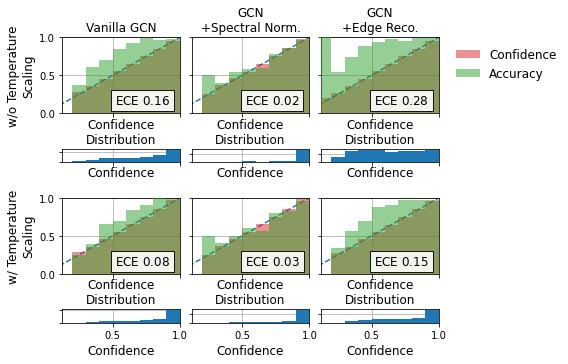

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from util import calibration_curve
from metrics import expected_calibration_error

fig, axs = plt.subplots(4, 3, figsize=(9 * .75, 7 * .75), sharex=True, sharey=False, squeeze=False, gridspec_kw = {
            'height_ratios' : [0.85, 0.15] * 2,
            'wspace' : .1,
            'hspace' : .8,
    })


for row, _line in enumerate([
    [('Vanilla GCN', scores_pred), ('GCN\n+Spectral Norm.', scores_pred_sn), ('GCN\n+Edge Reco.', scores_pred_rc)],
    [('Vanilla GCN', scores_pred_ts), ('GCN\n+Spectral Norm.', scores_pred_sn_ts), 
     ('GCN\n+Edge Reco.', scores_pred_rc_ts)],
]):
    for col, (name, probs) in enumerate(_line):
        pass

    
        edges, bin_conf, bin_acc, bin_density = calibration_curve(probs, y_true, bins=10, eps=1e-12)
        ece = expected_calibration_error(probs, y_true, bins=10)
        widths = edges[1:] - edges[:-1]
        centers = 0.5 * (edges[1:] + edges[:-1])

        ax = axs[2 * row, col]
        ax.plot([0, 1], [0, 1], ls='--')
        ax.bar(centers, bin_conf, widths, label='Confidence', alpha=0.5, color='tab:red', zorder=4)
        ax.bar(centers, bin_acc, widths, label='Accuracy', alpha = 0.5, color='tab:green', zorder=4)

        axs[2 * row + 1, col].bar(centers, bin_density, widths, label='Density', zorder=4)
        if row == 0:
            ax.set_title(name, fontsize=12)
        axs[2 * row + 1, col].set_title('Confidence\nDistribution')

        props = dict(alpha=0.9, facecolor='white', edgecolor=None)
        # place a text box in upper left in axes coords
        ax.text(0.45, 0.25, f'ECE ${ece:.2f}$', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props, zorder=5)

        if col > 0:
            ax.set_yticklabels([])

        if col == axs.shape[1] - 1 and row == 0:
            legend = ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1.0))
            legend.get_frame().set_facecolor('none')
            legend.get_frame().set_edgecolor('none')

        ax.set_ylim(0, 1.0)
        ax.set_xlim(1 / probs.size(1), 1.0)
        ax.grid(which='major', axis='both')
        axs[2 * row + 1, col].grid(which='major', axis='both')
        axs[2 * row + 1, col].set_yticklabels([])
        axs[2 * row + 1, col].set_xlabel(r'Confidence', fontsize=12)
        
axs[0, 0].set_ylabel('w/o Temperature\nScaling', fontsize=12)
axs[2, 0].set_ylabel('w/ Temperature\nScaling', fontsize=12)

path = f'thesis_nbs/reliability_diagrams-{dataset}.pdf'
fig.savefig(path, bbox_inches='tight')
print(path)